# Computation of virtual orbitals and check of the completeness relation for $N_2$

We compute the virtual orbitals of the $N_2$ molecule and evalute the maximum energy sampled by the system. Then we use this basis to express the occupied orbitals of the same molecule subjected to a static electric field.

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'virtual-orbitals/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

## Computation of the virtual orbitals (cubic code)

The aim of this computation is to produce the set of virtual orbitals, up to the highest value specified by the 'virtMax' parameter with a maximum residue of $1e^{-4}$. To obtain this result we produce a list of virtual orbitals denoted as 'virt' (using a linear spacing). virt contains a number of virtual orbitals higher than virtMax, because the last elements have a higher residue and are included only to improve the convergence of the lower ones.

The computation is performed for rMult = 7.0, but the code is written in a way prone to the inclusion of other values.

In [3]:
virt=[16,32,64,128,256,320]
print virt
rVal = [7.0]

[16, 32, 64, 128, 256, 320]


We run the first set of calculation with 'itermax_virt' in the range 20-30. In this way we build a first guess of the virtual orbitals. Further refinement are performed later. We build the input file:

In [4]:
for r in rVal:
    inp={'dft':{
          'rmult': [r, 9.0],
          'itermax_virt' : 20,
          'gnrm_cv_virt' : 1e-4},
         'output': {
          'orbitals' : 'binary',
          'verbosity' : 3}
        }
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in virt:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_'+str(r))

and execute the computation via the run file:

In [5]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
for r in rVal:
    code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_7.0 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We read the log files associated to the highest number of virtual orbitals and organize them in the lists Data.

In [4]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

[Errno 2] No such file or directory: 'virtual-orbitals/'
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We extract the value of the residue od the each orbital and plot it (we also display the reference value).

The value 18 is the last iteration value (20 nominal iteration but for the last one the residue are not computed)

In [5]:
residues = Data[0].log['Optimization of virtual orbitals'][18]['Residues per orbital']

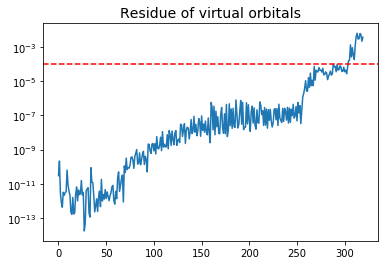

In [6]:
plt.plot(residues)
plt.axhline(y=1e-4, color='r', linestyle='--')
plt.title('Residue of virtual orbitals',fontsize=14)
plt.yscale('log')
plt.show()

On the basis of this plot we set the number of virtual orbitals with the chosen level of confidence

In [10]:
errMax = 1e-4
notExcede = True
i = 0
while (notExcede):
    if residues[i] > errMax:
        notExcede = False
    i+=1

    virtMax = i-2
print 'virtMax = ', virtMax, 'res = ', residues[virtMax]

virtMax =  303 res =  6.70999565244e-05


To refine the result we perform the computation again (with a higher value of 'itermax_virt') and if needed we repeat the computation starting from the number of virtual orbitals that exceed the maximum allowed value:

In [11]:
virt_reduced = [288, 304 ,320]
print virt_reduced

[288, 304, 320]


In [38]:
for r in rVal:
    inp={'dft':{
          'rmult': [r, 9.0],
          'itermax_virt' : 20,
          'gnrm_cv_virt' : 1e-4},
         'output': {
          'orbitals' : 'binary',
          'verbosity' : 3}
        }
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in virt_reduced:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_reduced_'+str(r))

we execute againg the selected input files

In [39]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
for r in rVal:
    code.run(run_name='runs_reduced_'+str(r),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_reduced_7.0 -d ./log/
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We proceed with the refinement up to the choosen level of precision.

We observe that the last computation performed is the one with the highest number of virtual orbitals, so the orbitals written on file are associated to this log, and we have to refer to it in order to correctly attribute energy and other paramters associated to them.

## Scaling of the energy vs. number of virtual orbitals

We read data in the log associated to a specific number of virtual orbitals

In [12]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We build the array with the energy of the empty orbitals, up to virtMax. Results are expressed in eV

In [13]:
numOccOrb = 5
engVirt = 27.211*Data[0].evals[0][0][numOccOrb:numOccOrb+virtMax-1]

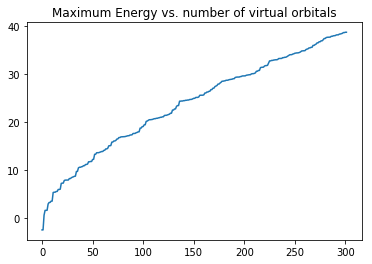

In [14]:
plt.plot(engVirt)
plt.title('Maximum Energy vs. number of virtual orbitals',fontsize=12)
plt.show()

We also plot the difference of the energy between two adiacent virtual orbitals:

In [48]:
deltaEng = []
for i in range(len(engVirt)-1):
    deltaEng.append(engVirt[i+1]-engVirt[i])

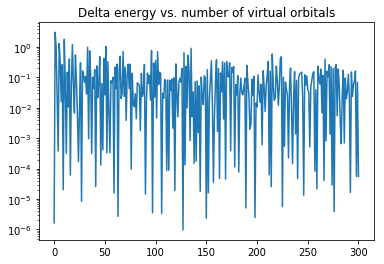

In [49]:
plt.plot(deltaEng)
plt.title('Delta energy vs. number of virtual orbitals',fontsize=12)
plt.yscale('log')
plt.show()

## Expansion of the perturbed KS orbitals (cubic code)

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e^{-2}$ both in the $z$ and $x$ directions. First of all we we build the input file, perform the computations and read the results.

### Generation of the input files and execution of the computations

In [50]:
for r in rVal:
    psip_Ex = '../static-field/log/data-Ex_1em2_rmult_'+str(r) #relative path starting from outputpath
    psip_Ez = '../static-field/log/data-Ez_1em2_rmult_'+str(r)
    inpEx={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax,
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ex}}
    inpEz={'dft':
           {'rmult': [r, 9.0],
            'norbv': -virtMax,
            'itermax_virt' : 1},
           'output': {'orbitals' : 'No'},
           'radical': 'Rmult_'+str(r),
           'tddft':{'decompose_perturbation': psip_Ez}}
    InpnameEx = 'CR_Ex_rmult_'+str(r)+'_numVirt_'+str(virtMax)
    InpnameEz = 'CR_Ez_rmult_'+str(r)+'_numVirt_'+str(virtMax)

    Yaml.dump(inpEz,outputpath + InpnameEz + '.yaml')
    Yaml.dump(inpEx,outputpath + InpnameEx + '.yaml')
    # execute the input files
    %cd $outputpath
    code.run(name=InpnameEx,skip=True,outdir='./log/')
    code.run(name=InpnameEz,skip=True,outdir='./log/')
    %cd ../



/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ex_rmult_7.0_numVirt_303 -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n CR_Ez_rmult_7.0_numVirt_303 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [15]:
# read the data. First index for the value of rmult, second index for the direction of the field
CR_data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-CR_E*_rmult_'+str(r)+'_numVirt_'+str(virtMax)+'.yaml'
    logs = !ls $spath
    print logs
    CR_data.append([lf.Logfile(l) for l in logs])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/virtual-orbitals
['log/log-CR_Ex_rmult_7.0_numVirt_303.yaml', 'log/log-CR_Ez_rmult_7.0_numVirt_303.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


### Data analysis

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

#### Electric Field in the $x$ direction

rmult =  7.0
no_occ 5 n_vrt 303
sqrt(1-psiprime) [ 0.00126604  0.01044635  0.01161932  0.00656206  0.00910798]


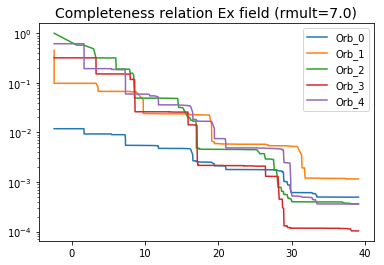

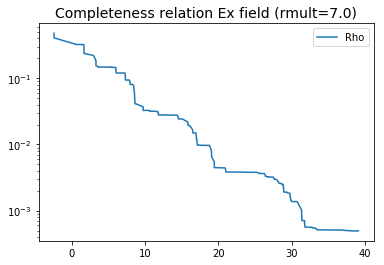

In [52]:
reload(R)
r = 0
print 'rmult = ', rVal[r]
e_v,cr=R.completeness_relation_new(CR_data[0][0])

rhoPlot = False
R.crplot_new(e_v,cr,'Ex field (rmult='+str(rVal[r])+')',rhoPlot,True)
plt.show()
rhoPlot = True
R.crplot_new(e_v,cr,'Ex field (rmult='+str(rVal[r])+')',rhoPlot,True)
plt.show()

#### Electric Field in the $z$ direction

rmult = § 7.0
no_occ 5 n_vrt 303
sqrt(1-psiprime) [ 0.00111001  0.00759847  0.0116082   0.01160818  0.01431058]


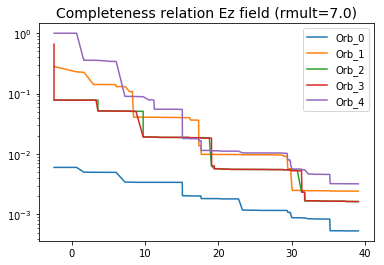

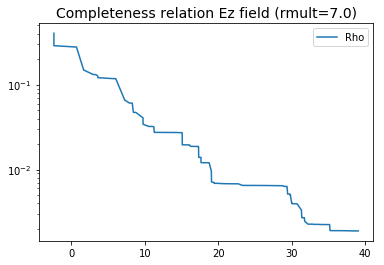

In [53]:
reload(R)
r = 0
print 'rmult = §', rVal[r]
e_v,cr=R.completeness_relation_new(CR_data[0][1])

rhoPlot = False
R.crplot_new(e_v,cr,'Ez field (rmult='+str(rVal[r])+')',rhoPlot,True)
plt.show()
rhoPlot = True
R.crplot_new(e_v,cr,'Ez field (rmult='+str(rVal[r])+')',rhoPlot,True)
plt.show()